Mount drive to load datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


import required packages

In [ ]:
import os
import cv2
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder, DatasetFolder
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torchvision.transforms import ToTensor
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
import warnings
from sklearn.model_selection import KFold
warnings.filterwarnings("ignore")

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyper-parameters 
num_epochs = 4
batch_size = 4
learning_rate = 0.01

In [ ]:
def load_dataset(directory_path):
  image_transforms = transforms.Compose(
                    [transforms.Resize((32,32)),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])
  
  dataset = ImageFolder(
                        root = directory_path,
                        transform = image_transforms
                        )
  return dataset

directory_path = "/content/drive/My Drive/dataset2"
dataset = load_dataset(directory_path)

In [ ]:
#verify classes extracted from dataset
classes = dataset.classes
classes

['not_a_person', 'with_mask', 'without_mask']

In [ ]:
#split into training and testing datasets
train_size = int(0.8 * len(dataset))
test_size = (len(dataset) - train_size)
train_dataset, test_dataset = random_split(dataset, (train_size, test_size))

In [ ]:
#import datasets as train_loader and test_loader using dataloader
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size= batch_size, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, shuffle=True,  batch_size= batch_size)

In [ ]:
#nn.Module - Base class for all neural network modules
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 3, padding =1 ),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels = 32 , out_channels = 32, kernel_size = 3, padding =1 ), 
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),     
            nn.MaxPool2d(kernel_size=2, stride =2),    
            nn.Conv2d(in_channels = 32 , out_channels = 64, kernel_size = 3, padding =1 ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),           
            nn.Conv2d(in_channels = 64 , out_channels = 64, kernel_size = 3, padding =1 ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride =2),                    
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(8*8*64,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512,256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, 3)        
        )
    
    def forward(self, x):
        #conv layers
        x = self.conv_layer(x)
        #flatten
        x = x.view(x.size(0), -1)
        #fc layer
        x = self.fc_layer(x)
        return x
    

In [ ]:
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [ ]:
#method to train the model
def train_model(train_loader):
  total_steps = len(train_loader)
  
  for epoch in range(num_epochs):
      total_train = 0
      correct_train = 0
      for i, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # accuracy
          _, predicted = torch.max(outputs, 1)
          total_train += labels.nelement() #no of pixels in batch
          correct_train += predicted.eq(labels.data).sum().item()
          train_accuracy = 100 * correct_train / total_train

          if (i+1) % 100 == 0:
              print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}')

  print('Training complete')
  PATH = './cnn.pth'
  torch.save(model.state_dict(), PATH)


In [ ]:
#method to test the model
def test_model(test_loader):
  with torch.no_grad():
      correct = 0
      total = 0
      correct_class = [0 for i in range(3)]
      total_class = [0 for i in range(3)]
      all_labels = []
      all_predicted = []
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          all_labels.append(labels)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          all_predicted.append(predicted)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          
          for i in range(batch_size):
              label = labels[i]
              pred = predicted[i]
              if (label == pred):
                  correct_class[label] += 1
              total_class[label] += 1
      acc = 100.0 * correct / total

      for i in range(3):
          acc = 100.0 * correct_class[i] / total_class[i]
          print(f'Accuracy of {classes[i]}: {round(acc,2)} %')
      
      return (all_labels,all_predicted) 

In [ ]:
#method to evaluate the model using classifictaion report
def evaluate_model(all_labels,all_predicted):
  np_arr1 = []
  for label in all_labels:
    np_arr1.append(label.cpu().detach().numpy())
  all_labels_np = np.asarray(np_arr1).ravel()

  np_arr2 = []
  for label in all_predicted:
    np_arr2.append(label.cpu().detach().numpy())
  all_predicted_np = np.asarray(np_arr2).ravel()
  print("Total Accuracy    : ", str(round(accuracy_score(all_labels_np,all_predicted_np)*100,2)), '%')
  target_names= ['not_a_person', 'with_mask', 'without_mask']
  all_scores = classification_report(all_labels_np, all_predicted_np, target_names=target_names)
  print(all_scores)
  return (all_labels_np,all_predicted_np)

  

In [ ]:
#method to print confusion matrix
def printConfusionMatrix(all_labels_np,all_predicted_np):
  cf_matrix = confusion_matrix(all_labels_np,all_predicted_np)
  sns.heatmap(cf_matrix, annot=True, cmap='rocket_r', xticklabels=classes, yticklabels=classes, fmt='d')
  plt.title('Confusion Matrix')


Epoch [1/4], Step [100/1008], Loss: 0.8400, Accuracy: 55.2500
Epoch [1/4], Step [200/1008], Loss: 0.2174, Accuracy: 68.8750
Epoch [1/4], Step [300/1008], Loss: 0.6163, Accuracy: 74.3333
Epoch [1/4], Step [400/1008], Loss: 0.0133, Accuracy: 77.5625
Epoch [1/4], Step [500/1008], Loss: 0.1044, Accuracy: 79.9500
Epoch [1/4], Step [600/1008], Loss: 0.2257, Accuracy: 81.8333
Epoch [1/4], Step [700/1008], Loss: 0.0994, Accuracy: 82.9643
Epoch [1/4], Step [800/1008], Loss: 0.4191, Accuracy: 83.6875
Epoch [1/4], Step [900/1008], Loss: 0.4057, Accuracy: 84.3889
Epoch [1/4], Step [1000/1008], Loss: 0.1726, Accuracy: 84.8000
Epoch [2/4], Step [100/1008], Loss: 0.0078, Accuracy: 92.7500
Epoch [2/4], Step [200/1008], Loss: 0.0545, Accuracy: 93.1250
Epoch [2/4], Step [300/1008], Loss: 0.0680, Accuracy: 93.1667
Epoch [2/4], Step [400/1008], Loss: 0.0380, Accuracy: 92.9375
Epoch [2/4], Step [500/1008], Loss: 0.2388, Accuracy: 93.2000
Epoch [2/4], Step [600/1008], Loss: 0.0490, Accuracy: 93.2500
Epoch [

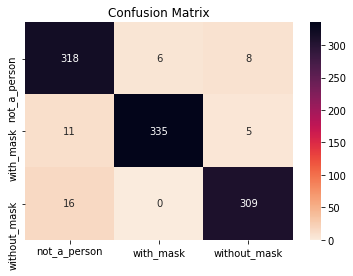

In [ ]:
#The training phase
train_model(train_loader)
#The testing phase
all_labels,all_predicted = test_model(test_loader)
#The evaluation phase
all_labels_np,all_predicted_np = evaluate_model(all_labels,all_predicted)
#confusion matrix
printConfusionMatrix(all_labels_np,all_predicted_np)

In [ ]:
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)
# enumerate splits
all_accuracy = []
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(dataset,batch_size=10, sampler=test_subsampler)
  print('pass',fold)
  train_model(train_loader)
  all_labels,all_predicted = test_model(test_loader)
  all_labels_np,all_predicted_np = evaluate_model(all_labels,all_predicted)
  accuracy = accuracy_score(all_labels_np,all_predicted_np)* 100
  all_accuracy.append(accuracy)  


pass 0
Epoch [1/4], Step [100/1008], Loss: 0.0760, Accuracy: 95.5000
Epoch [1/4], Step [200/1008], Loss: 0.0302, Accuracy: 96.0000
Epoch [1/4], Step [300/1008], Loss: 0.1325, Accuracy: 96.4167
Epoch [1/4], Step [400/1008], Loss: 0.5656, Accuracy: 96.5625
Epoch [1/4], Step [500/1008], Loss: 0.0024, Accuracy: 96.4500
Epoch [1/4], Step [600/1008], Loss: 0.0031, Accuracy: 96.0417
Epoch [1/4], Step [700/1008], Loss: 0.0131, Accuracy: 96.1429
Epoch [1/4], Step [800/1008], Loss: 0.0049, Accuracy: 96.2500
Epoch [1/4], Step [900/1008], Loss: 0.0075, Accuracy: 96.0833
Epoch [1/4], Step [1000/1008], Loss: 0.0211, Accuracy: 96.2250
Epoch [2/4], Step [100/1008], Loss: 0.0053, Accuracy: 98.2500
Epoch [2/4], Step [200/1008], Loss: 0.0198, Accuracy: 97.7500
Epoch [2/4], Step [300/1008], Loss: 0.2919, Accuracy: 97.8333
Epoch [2/4], Step [400/1008], Loss: 0.0286, Accuracy: 97.5000
Epoch [2/4], Step [500/1008], Loss: 0.0398, Accuracy: 97.3000
Epoch [2/4], Step [600/1008], Loss: 0.0019, Accuracy: 97.2917


In [ ]:
print('K fold accuracy :',str(round(sum(all_accuracy) / len(all_accuracy),2) ),'%')

K fold accuracy : 96.37 %
